In [41]:
from pymongo import MongoClient
import json
import requests
import pandas as pd
import plotly.express as px
from collections import OrderedDict

In [24]:
# Create client and load in Fraud database
client = MongoClient()
db = client["Fraud"]
fraud_data = db["FraudData"]

## Visualizations 

### Count of fraud transactions

In [32]:
# Group by if it is fraud, counting the number of transactions
stage_group_fraud = {
    "$group": {
        "_id": "$isFraud", 
        "count": {"$sum": 1}
    }
}

pipeline = [
    stage_group_fraud
]

count_fraud = fraud_data.aggregate(pipeline)
count_fraud = pd.DataFrame(list(count_fraud))

In [34]:
fig = px.bar(count_fraud,x="_id",y="count",
              labels={"amount": "Count","_id":"isFraud"},title="Count of fraudulent transactions")

In [35]:
fig.show()

### Count of transaction types

In [36]:
# Group by transaction type, counting the number of transactions
stage_group_trans = {
    "$group": {
        "_id": {
            "transaction_type": "$type"
        },
        "count": {"$sum": 1}
    }
}

stage_project = {
    "$project": {
        "transaction_type": "$_id.transaction_type",
        "count": "$count",
        "_id": 0
    }
}

pipeline = [
    stage_group_trans,
    stage_project
]

count_trans = fraud_data.aggregate(pipeline)
count_trans = pd.DataFrame(list(count_trans))

In [37]:
count_trans

,transaction_type,count
0,CASH_IN,1399284
1,DEBIT,41432
2,CASH_OUT,2237500
3,PAYMENT,2151495
4,TRANSFER,532909


In [38]:
fig2 = px.bar(count_trans,x="transaction_type",y="count",
              labels={"count": "Count"},title="Count of each transaction type:")

In [39]:
fig2.show()

### Average amount by transaction type

In [79]:
# Group by transaction type
stage_group_trans = {
    "$group": {
        "_id": {
            "transaction_type": "$type"
        },
        "avg": {"$avg": "$amount"}
    }
}

stage_project = {
    "$project": {
        "transaction_type": "$_id.transaction_type",
        "avg": "$avg",
        "_id": 0
    }
}

stage_sort = {
    "$sort": OrderedDict([("transaction_type", 1), ("is_fraud", 1)])
}

pipeline = [
    stage_group_trans,
    stage_project,
    stage_sort
]

avg_by_type = fraud_data.aggregate(pipeline)
avg_by_type = pd.DataFrame(list(avg_by_type))

In [81]:
avg_by_type

,transaction_type,avg
0,CASH_IN,168920.242004
1,CASH_OUT,176273.964346
2,DEBIT,5483.665314
3,PAYMENT,13057.604660
4,TRANSFER,910647.009645


In [83]:
px.bar(avg_by_type,x="transaction_type",y="avg",
              labels={"avg": "Average","transaction_type":"Transaction Type"},title="Average amount by transaction type")

In [84]:
# Group by transaction type, fraud, counting the number of transactions
stage_group_trans = {
    "$group": {
        "_id": {
            "transaction_type": "$type",
            "is_fraud": "$isFraud"
        },
        "avg": {"$avg": "$amount"}
    }
}

stage_project = {
    "$project": {
        "transaction_type": "$_id.transaction_type",
        "is_fraud": "$_id.is_fraud",
        "avg": "$avg",
        "_id": 0
    }
}

stage_sort = {
    "$sort": OrderedDict([("transaction_type", 1), ("is_fraud", 1)])
}

pipeline = [
    stage_group_trans,
    stage_project,
    stage_sort
]

avg_by_isfraud = fraud_data.aggregate(pipeline)
avg_by_isfraud = pd.DataFrame(list(avg_by_isfraud))

In [87]:
fig6 = px.histogram(avg_by_isfraud, x="transaction_type", y="avg", title="Average amount by transaction type and fraud status",
             color='is_fraud', barmode='group',
             height=500)
fig6.show()

### Count of transaction types by isFraud 

In [42]:
# Group by transaction type, fraud, counting the number of transactions
stage_group_trans = {
    "$group": {
        "_id": {
            "transaction_type": "$type",
            "is_fraud": "$isFraud"
        },
        "count": {"$sum": 1}
    }
}

stage_project = {
    "$project": {
        "transaction_type": "$_id.transaction_type",
        "is_fraud": "$_id.is_fraud",
        "count": "$count",
        "_id": 0
    }
}

stage_sort = {
    "$sort": OrderedDict([("transaction_type", 1), ("is_fraud", 1)])
}

pipeline = [
    stage_group_trans,
    stage_project,
    stage_sort
]

count_type_fraud = fraud_data.aggregate(pipeline)
count_type_fraud = pd.DataFrame(list(count_type_fraud))

In [66]:
fig4 = px.histogram(count_type_fraud, x="transaction_type", y="count", title="All transaction type counts, by fraud status",
             color='is_fraud', barmode='group',
             height=500)
fig4.show()

In [67]:
fraud_types_only = count_type_fraud[(count_type_fraud['transaction_type']=='CASH_OUT') | (count_type_fraud['transaction_type']=='TRANSFER')]

In [69]:
fig5 = px.histogram(fraud_types_only, x="transaction_type", y="count", title="Transfer and Cashout counts by Fraud Status",
             color='is_fraud', barmode='group',
             height=500)
fig5.show()

In [148]:
#General distribution for each type for model input types (only those where isFraud can equal 1)

In [159]:
# Filter only for payment transactions that are TRANSFER or CASH_OUT
stage_filter_trans = {
    "$match": {
        "type": {"$in": ["TRANSFER", "CASH_OUT"]},
    }
}

stage_project = {
    "$project": {
        "is_transfer": {
            "$cond": { 
                "if": {"$eq": ["$type", "TRANSFER"]}, "then": 1, "else": 0}
        },
        "amount": "$amount",
        "isFraud": "$isFraud",
        "_id": 0
    }
}

pipeline = [
    stage_filter_trans,
    stage_project
]

results = fraud_data.aggregate(pipeline)

In [160]:
results = pd.DataFrame(list(results))

In [161]:
transfer_amts=results[results['is_transfer']==1]
cashout_amts=results[results['is_transfer']==0]

<AxesSubplot:>

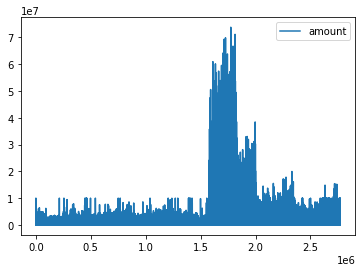

In [163]:
transfer_amts.plot(y='amount')

<AxesSubplot:>

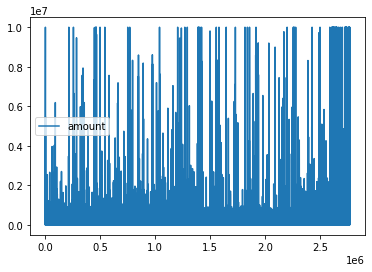

In [146]:
cashout_amts.plot(y='amount')

In [180]:
nonfraud_transfer = transfer_amts[transfer_amts['isFraud']==0]
fraud_transfer = transfer_amts[transfer_amts['isFraud']==1]
nonfraud_cashout = cashout_amts[cashout_amts['isFraud']==0]
fraud_cashout = cashout_amts[cashout_amts['isFraud']==1]

### Non-fraud transfer histogram

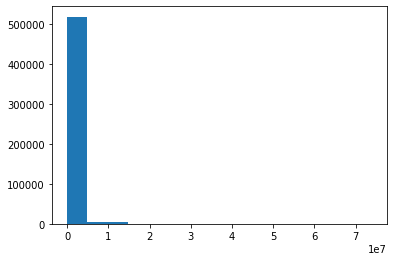

In [176]:
fig = plt.hist(np.array(nonfraud_transfer['amount']), bins=15)

### Fraud transfer histogram

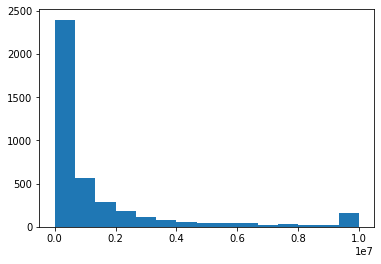

In [179]:
fig2 = plt.hist(np.array(fraud_transfer['amount']), bins=15)

### Non-fraud cashout histogram

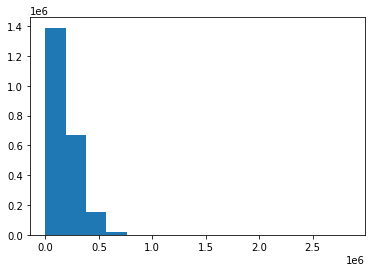

In [181]:
fig = plt.hist(np.array(nonfraud_cashout['amount']), bins=15)

### Fraud cashout histogram

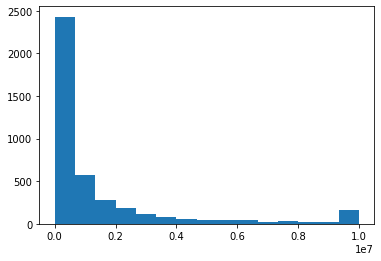

In [182]:
fig = plt.hist(np.array(fraud_cashout['amount']), bins=15)